# 

In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')
c_multi_gamma_prob_v1d_x = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)
c_multi_gamma_sf_v1d_x = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

In [199]:
dist = 20
z = -500
rho = 0.0
zenith = 1.57
azimuth = 3.9264083

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [200]:
xvals = np.linspace(-20, 100, 1000)
probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.1)

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


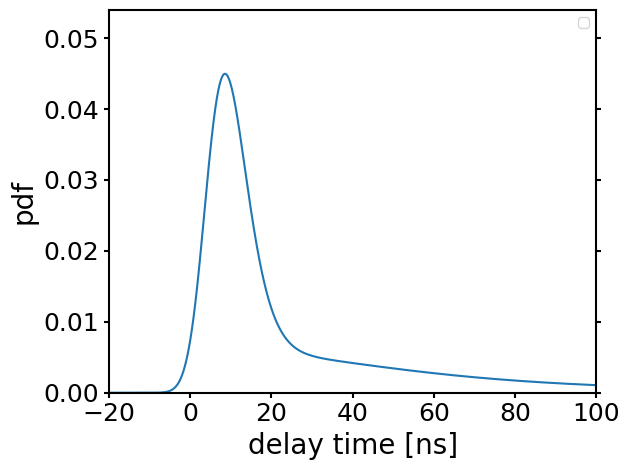

In [201]:
fig, ax = plt.subplots()
plt.plot(xvals, probs)
plot_args = {'xlim':[-20, 100],
                     'ylim':[0.0, 1.2 * np.amax(probs)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

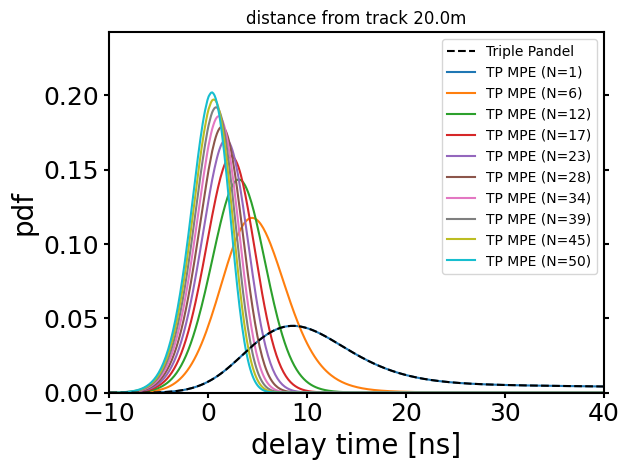

In [202]:
probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0)

fig, ax = plt.subplots()
plt.plot(xvals, probs,linestyle='dashed', color='black', zorder=100, label='Triple Pandel')

y_max = np.amax(probs)
n_photons = jnp.array(np.linspace(1, 50, 10))
for n_p in n_photons:
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})')
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 40],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [203]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [204]:
gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=gamma_a,
                    rate=gamma_b,
                    force_probs_to_zero_outside_support=True
                      )
                )

probs = gm.prob(xvals)
sfs = gm.survival_function(xvals)

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


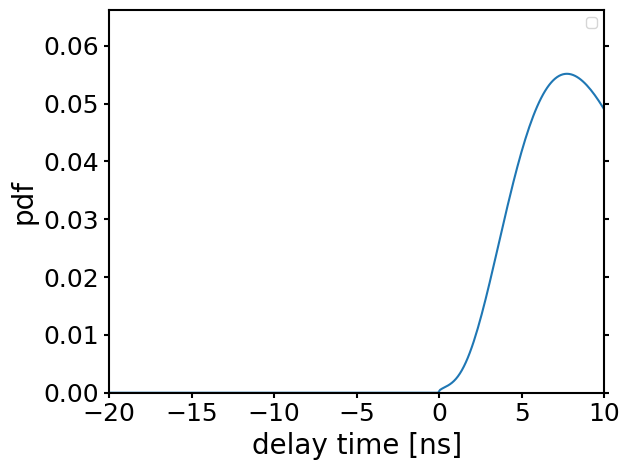

In [205]:
fig, ax = plt.subplots()
plt.plot(xvals, probs)
plot_args = {'xlim':[-20, 10],
                     'ylim':[0.0, 1.2 * np.amax(probs)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

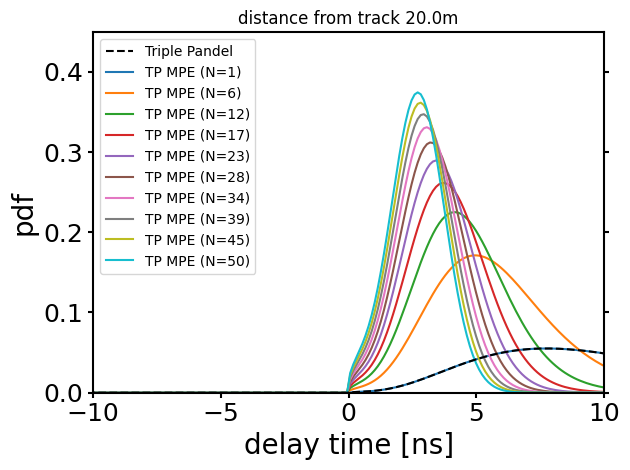

In [206]:
fig, ax = plt.subplots()
plt.plot(xvals, probs,linestyle='dashed', color='black', zorder=100, label='Triple Pandel')

y_max = np.amax(probs)
n_photons = jnp.array(np.linspace(1, 50, 10))
for n_p in n_photons:
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})')
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 10],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [207]:
@jax.jit
def convolved_mpe(x, logits, gamma_a, gamma_b, n_photons, sigma):
    
    gm = tfd.MixtureSameFamily(
                  mixture_distribution=tfd.Categorical(
                      logits=logits
                      ),
                  components_distribution=tfd.Gamma(
                    concentration=gamma_a,
                    rate=gamma_b,
                    force_probs_to_zero_outside_support=True
                      )
                )

    gn = tfp.distributions.Normal(
                x,
                sigma,
                validate_args=False,
                allow_nan_stats=False,
                name='Normal'
            )


    xmax = jnp.max(jnp.array([jnp.array(5 * sigma), x + 5 * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    xvals = jnp.linspace(xmin, xmax, 81)
    xvals = 0.5 * (xvals[1:]+xvals[:-1])
    dx = xvals[1] - xvals[0]
    
    probs_mpe = n_photons * gm.prob(xvals) * jnp.power(gm.survival_function(xvals), n_photons-1)
    probs_norm = gn.prob(xvals)

    return jnp.sum(probs_mpe * probs_norm) * dx
    
convolved_mpe_v1d_x = jax.jit(jax.vmap(convolved_mpe, (0, None, None, None, None, None), 0))

In [208]:
x = 0
sigma = 2.0

xmin = x - 6 * sigma
xmax = x + 6 * sigma
xvals = jnp.linspace(xmin, xmax, 41)
print(xvals)

[-1.2000000e+01 -1.1400000e+01 -1.0800000e+01 -1.0200000e+01
 -9.6000000e+00 -9.0000000e+00 -8.4000000e+00 -7.8000000e+00
 -7.2000000e+00 -6.6000000e+00 -6.0000000e+00 -5.4000000e+00
 -4.8000000e+00 -4.2000000e+00 -3.6000000e+00 -3.0000000e+00
 -2.4000000e+00 -1.8000000e+00 -1.2000000e+00 -6.0000000e-01
  8.8817842e-16  6.0000000e-01  1.2000000e+00  1.8000000e+00
  2.4000000e+00  3.0000000e+00  3.6000000e+00  4.2000000e+00
  4.8000000e+00  5.4000000e+00  6.0000000e+00  6.6000000e+00
  7.2000000e+00  7.8000000e+00  8.4000000e+00  9.0000000e+00
  9.6000000e+00  1.0200000e+01  1.0800000e+01  1.1400000e+01
  1.2000000e+01]


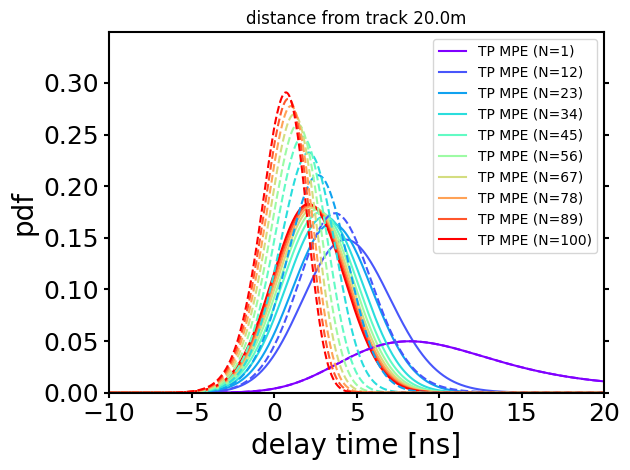

In [209]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0 
n_photons = jnp.array(np.linspace(1, 100, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_v1d_x(xvals, logits, gamma_a, gamma_b, n_p, 2.0)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 2.0, 0.1)
sfs = c_multi_gamma_sf_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 2.0)

for i, n_p in enumerate(n_photons):
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, linestyle='dashed', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [168]:
from scipy.integrate import quad

In [169]:
print(convolved_mpe(0.0, logits, gamma_a, gamma_b, 30, 2.0))

0.1471256740455259


In [170]:
f = lambda x: convolved_mpe(x, logits, gamma_a, gamma_b, 2, 3.0)

In [171]:
quad(f, -15.0, 100)[0] > 0.99

True

In [172]:
print(quad(f, -30.0, 10)[0])

1.008805006356111


In [198]:
'''
def find_charge_max(distance, min_charge, max_charge):
    dist = distance
    z = -500
    rho = 0.0
    zenith = 1.57
    azimuth = 3.9264083
    
    x = jnp.array([dist, rho, z, zenith, azimuth])
    x_prime = transform_network_inputs(x)
    y = eval_network(x_prime)
    logits, gamma_a, gamma_b = transform_network_outputs(y)

    mid_charge = np.round(0.5 * (min_charge + max_charge))
    f = lambda x: convolved_mpe(x, logits, gamma_a, gamma_b, mid_charge, 2.0)
    norm1 = quad(f, -15.0, 1000, epsabs=1.e-4)[0]
    f = lambda x: convolved_mpe(x, logits, gamma_a, gamma_b, mid_charge-1, 2.0)
    norm2 = quad(f, -15.0, 1000, epsabs=1.e-4)[0]
    print(mid_charge, norm1, norm2)
    
    if norm1 < 0.99:
        if norm2 > 0.99:
            return mid_charge-1, norm2
        else:
            charge, norm = find_charge_max(distance, min_charge, mid_charge)
    else:
        charge, norm = find_charge_max(distance, mid_charge, max_charge)

    return charge, norm
''' 

'\ndef find_charge_max(distance, min_charge, max_charge):\n    dist = distance\n    z = -500\n    rho = 0.0\n    zenith = 1.57\n    azimuth = 3.9264083\n    \n    x = jnp.array([dist, rho, z, zenith, azimuth])\n    x_prime = transform_network_inputs(x)\n    y = eval_network(x_prime)\n    logits, gamma_a, gamma_b = transform_network_outputs(y)\n\n    mid_charge = np.round(0.5 * (min_charge + max_charge))\n    f = lambda x: convolved_mpe(x, logits, gamma_a, gamma_b, mid_charge, 2.0)\n    norm1 = quad(f, -15.0, 1000, epsabs=1.e-4)[0]\n    f = lambda x: convolved_mpe(x, logits, gamma_a, gamma_b, mid_charge-1, 2.0)\n    norm2 = quad(f, -15.0, 1000, epsabs=1.e-4)[0]\n    print(mid_charge, norm1, norm2)\n    \n    if norm1 < 0.99:\n        if norm2 > 0.99:\n            return mid_charge-1, norm2\n        else:\n            charge, norm = find_charge_max(distance, min_charge, mid_charge)\n    else:\n        charge, norm = find_charge_max(distance, mid_charge, max_charge)\n\n    return charge, 

In [174]:
'''
distances = np.linspace(1.0, 20.0, 20)

cuts = [5.0]
norms = [0.0]
for dist in distances:
    print(f"distance: {dist}") 
    thresh, norm = find_charge_max(dist, cuts[-1]-2, 10*cuts[-1])
    cuts.append(thresh)
    norms.append(norm)
'''

'\ndistances = np.linspace(1.0, 20.0, 20)\n\ncuts = [5.0]\nnorms = [0.0]\nfor dist in distances:\n    print(f"distance: {dist}") \n    thresh, norm = find_charge_max(dist, cuts[-1]-2, 10*cuts[-1])\n    cuts.append(thresh)\n    norms.append(norm)\n'

In [175]:
c_multi_gamma_prob_jitted = jax.jit(c_multi_gamma_prob)
c_multi_gamma_sf_jitted = jax.jit(c_multi_gamma_sf)

In [176]:
print(c_multi_gamma_prob_jitted(0.0, mix_probs, gamma_a, gamma_b, 3.0))
print(c_multi_gamma_sf_jitted(0.0, mix_probs, gamma_a, gamma_b, 3.0))

0.11723205317207942
0.6242539586792903


In [210]:
@jax.jit
def conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons):
    p = c_multi_gamma_prob(x, mix_probs, gamma_a, gamma_b, sigma)
    sf = c_multi_gamma_sf(x, mix_probs, gamma_a, gamma_b, sigma)
    return n_photons * p * jnp.power(sf, (n_photons-1))

def norm_mpe_pdf(mix_probs, gamma_a, gamma_b, sigma, n_photons):
    f = lambda x: conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons)
    return  quad(f, -15, 100, epsabs=1.e-4)[0]

def mean_conv_mpe_pdf(mix_probs, gamma_a, gamma_b, sigma, n_photons):
    f = lambda x: x * conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons)
    return quad(f, -15, 100, epsabs=1.e-4)[0]

def second_moment_conv_mpe_pdf(mix_probs, gamma_a, gamma_b, sigma, n_photons):
    f = lambda x: x**2 * conv_mpe_pdf(x, mix_probs, gamma_a, gamma_b, sigma, n_photons)
    return quad(f, -15, 100, epsabs=1.e-4)[0]

In [219]:
norm = norm_mpe_pdf(mix_probs, gamma_a, gamma_b, 3.0, 60)
print(norm)
mean = mean_conv_mpe_pdf(mix_probs, gamma_a, gamma_b, 3.0, 60)
print(mean)
second_moment = second_moment_conv_mpe_pdf(mix_probs, gamma_a, gamma_b, 3.0, 60)
err = np.sqrt(second_moment - mean**2)
print(err)

1.0007606733984076
-0.30971238121606853
1.9753729397001847


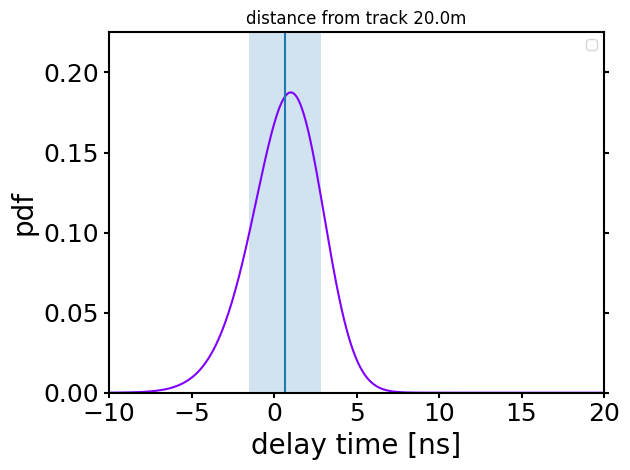

In [215]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0 
n_photons = [35]
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

probs = c_multi_gamma_prob_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0, 0.01)
sfs = c_multi_gamma_sf_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 3.0)

for i, n_p in enumerate(n_photons):
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 20],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

ax.axvline(mean)
ax.axvspan(mean-err, mean+err, alpha=0.2)
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [195]:
def find_charge_max(distance, min_charge, max_charge):
    dist = distance
    z = -500
    rho = 0.0
    zenith = 1.57
    azimuth = 3.9264083
    
    x = jnp.array([dist, rho, z, zenith, azimuth])
    x_prime = transform_network_inputs(x)
    y = eval_network(x_prime)
    logits, gamma_a, gamma_b = transform_network_outputs(y)

    mid_charge = (min_charge + max_charge)//2

    sigma = 3.0
    mean1 = mean_conv_mpe_pdf(mix_probs, gamma_a, gamma_b, sigma, mid_charge)
    mean2 = mean_conv_mpe_pdf(mix_probs, gamma_a, gamma_b, sigma, mid_charge-1)
    #print(mid_charge, mean1, mean2)
    
    if mean1 < 0.0:
        if mean2 > 0.0:
            return mid_charge
        else:
            charge = find_charge_max(distance, min_charge, mid_charge-1)
    else:
        charge = find_charge_max(distance, mid_charge+1, max_charge)

    return charge

In [183]:
find_charge_max(1.0, 2.0, 10.0)

6.0 -3.041001555776393 -2.7013254391690036
3.0 -1.6694676577126728 -0.6704915670890824
2.0 -0.6704915670890824 2.2767098798073215


2.0

In [185]:
find_charge_max(2.0, 2.0, 10.0)

11.0 -4.106950183726346 -3.9434414154942115
6.0 -3.0375809962997002 -2.696997090812916
3.0 -1.6641719419878516 -0.6635691631567577
2.0 -0.6635691631567577 2.302587569542232


2.0

In [186]:
find_charge_max(3.0, 2.0, 10.0)

6.0 -2.6158903860606433 -2.2833580604325943
3.0 -1.2617736705818763 -0.26341973761321413
2.0 -0.26341973761321413 2.6945341156887084


2.0

In [187]:
find_charge_max(4.0, 2.0, 10.0)

6.0 -2.3632101705183803 -2.030165008748346
3.0 -1.0009821914429067 0.009062528621049611


3.0

In [188]:
find_charge_max(5.0, 3.0, 15.0)

9.0 -2.7729718412818 -2.5775193687193756
5.0 -1.7425506337531895 -1.309769714105553
3.0 -0.7057059394628231 0.3084359051202162


3.0

In [189]:
find_charge_max(6.0, 3.0, 15.0)

9.0 -2.5610293896480183 -2.3646414442238317
5.0 -1.525681017527874 -1.0908609020229865
3.0 -0.48444505840412194 0.5260859255504556


3.0

In [190]:
find_charge_max(7.0, 3.0, 15.0)

9.0 -2.3576509888928565 -2.160399599512489
5.0 -1.317779968914894 -0.8811340763401432
3.0 -0.2727369787569527 0.7331930006405618


3.0

In [191]:
find_charge_max(8.0, 3.0, 15.0)

9.0 -2.10733289305879 -1.9090538724404256
5.0 -1.0620768116268926 -0.6232541209595172
3.0 -0.012295781814501229 0.9923466457371347


3.0

In [192]:
find_charge_max(9.0, 3.0, 15.0)

9.0 -1.6642449125716257 -1.4577515415904556
5.0 -0.573000762201989 -0.1125475428545546
3.0 0.5323702586325919 1.6165763918906704
4.0 -0.1125475428545546 0.5323702586325919


4.0

In [194]:
find_charge_max(9.0, 4.0, 8.0)

6.0 -0.9286828573004813 -0.573000762201989
4.0 -0.1125475428545546 0.5323702586325919


4.0

In [196]:
distances = np.linspace(1.0, 20.0, 20)

cuts = [2.0]
for dist in distances:
    print(f"distance: {dist}") 
    thresh = find_charge_max(dist, cuts[-1], 2*cuts[-1])
    print(thresh)
    cuts.append(thresh)

distance: 1.0
2.0
distance: 2.0
2.0
distance: 3.0
2.0
distance: 4.0
3.0
distance: 5.0
3.0
distance: 6.0
3.0
distance: 7.0
3.0
distance: 8.0
3.0
distance: 9.0
4.0
distance: 10.0
5.0
distance: 11.0
6.0
distance: 12.0
7.0
distance: 13.0
9.0
distance: 14.0
10.0
distance: 15.0
13.0
distance: 16.0
16.0
distance: 17.0
19.0
distance: 18.0
23.0
distance: 19.0
29.0
distance: 20.0
35.0


In [1]:
plt.plot(np.linspace(0.0, 20.0, 21), cuts)

NameError: name 'plt' is not defined

In [220]:
find_charge_max(20.0, 20.0, 100.0)

51.0